In [ ]:
import os

import tqdm
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn

import vari
import vari.datasets
import vari.models
import vari.inference

from vari.layers import GaussianLayer, BernoulliLayer

from sklearn.datasets import make_circles

In [185]:
experiments_dir = '/nas/experiments/sacred/models/'
data_root = '/home/jdh/repos/vari/torch_data'
output_dir = f'{os.getcwd()}/plots'
plot_ext = '.svg'
mpl.style.use('default')

In [168]:
def get_constant_colormap(rgb_color):
    # Colormap that is constant at the given rgb_color.
    r, g, b = rgb_color
    cdict = {'red': [(0, r, r), (1, r, r)], 
             'green': [(0, g, g), (1, g, g)],
             'blue': [(0, b, b), (1, b, b)]}
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

## Select models and data

In [169]:
run_ids_mnist = {
    'VAE 1L 5IS': 6694,
    'VAE 1L 100IS': 6697,
    'VAE 2L 5IS': 6695,
    'VAE 2L 100IS': 6696,
}

run_ids_fashion_mnist = dict(
    vae1L=6619,
    vae3L=6625,
)

## Get data

In [170]:
mnist_train = vari.datasets.MNISTBinarized(split='train', preprocess='static', exclude_labels=[], root=data_root)
mnist_test1 = vari.datasets.MNISTBinarized(split='test', preprocess='static', exclude_labels=[], root=data_root)

In [171]:
fashion_mnist_train = vari.datasets.FashionMNISTBinarized(split='train', preprocess='deterministic', exclude_labels=[], root=data_root)
fashion_mnist_test1 = vari.datasets.FashionMNISTBinarized(split='test', preprocess='deterministic', exclude_labels=[], root=data_root)

### Visualize dataset

In [172]:
def plot_image_matrix(images, ax):
    rows = int(np.sqrt(len(images)))
    cols = rows
    image_rows = []
    for i in range(rows):
        image_rows += [np.concatenate(images[i*cols:(i+1)*cols], axis=1)]
    image_matrix = np.concatenate(image_rows, axis=0)
    ax.imshow(image_matrix, cmap='binary_r')
    ax.axis('off')

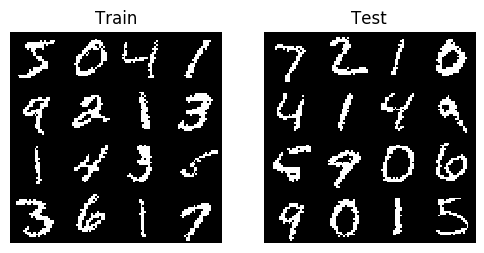

In [188]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');
fig.savefig(output_dir + f'/Dataset_MNIST' + plot_ext, bbox_inches='tight')

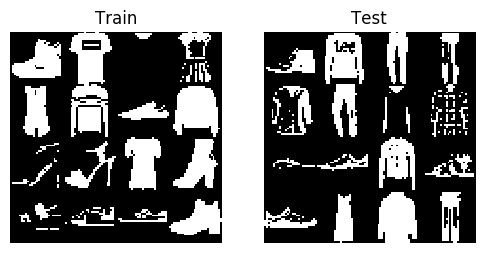

In [189]:
start_idx = 0
n_images = 4 * 4
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12))
plot_image_matrix(fashion_mnist_train.examples[start_idx: start_idx + n_images], ax1)
plot_image_matrix(fashion_mnist_test1.examples[start_idx: start_idx + n_images], ax2)
ax1.set_title('Train')
ax2.set_title('Test');
fig.savefig(output_dir + f'/Dataset_FashionMNIST' + plot_ext, bbox_inches='tight')

### Log Bernoulli distance between datasets

In [175]:
mnist_train_real = vari.datasets.MNISTReal(split='train', preprocess='deterministic', exclude_labels=[], root=data_root)
mnist_test1_real = vari.datasets.MNISTReal(split='test', preprocess='deterministic', exclude_labels=[], root=data_root)

In [176]:
fashion_mnist_train_real = vari.datasets.FashionMNISTReal(split='train', preprocess='deterministic', exclude_labels=[], root=data_root)
fashion_mnist_test1_real = vari.datasets.FashionMNISTReal(split='test', preprocess='deterministic', exclude_labels=[], root=data_root)

In [177]:
# Mean pixel activation
mnist_train_real.examples.mean(), fashion_mnist_train_real.examples.mean()

(0.13015018, 0.28492352)

In [178]:
# Average number of pixels activated above 0.5
(mnist_train_real.examples>0.5).sum(axis=(-1,-2)).mean(), \
(fashion_mnist_train_real.examples>0.5).sum(axis=(-1,-2)).mean()

(102.44141666666667, 245.35836666666665)

In [179]:
def log_bernoulli(x, p, eps=1e-8):
    return np.log(p + eps) * x + np.log(1 - p + eps) * (1 - x)

In [180]:
def nearest_neighbour_distance_bernoulli(x, p, ignore_diag):
    x = x[np.newaxis, ...]
    p = p[:, np.newaxis, ...]
    d = np.sum(log_bernoulli(x, p), axis=-1)
    if ignore_diag:
        np.fill_diagonal(d, val=np.nan)
    return np.nanmax(d, axis=-1)

In [191]:
n_samples = 1000
train = mnist_train_real.examples[:n_samples].reshape(-1, 784)
test1 = fashion_mnist_train_real.examples[:n_samples].reshape(-1, 784)
nnd_train_mnist = nearest_neighbour_distance_bernoulli(x=train, p=train, ignore_diag=True)
nnd_test1_mnist = nearest_neighbour_distance_bernoulli(x=test1, p=train, ignore_diag=False)

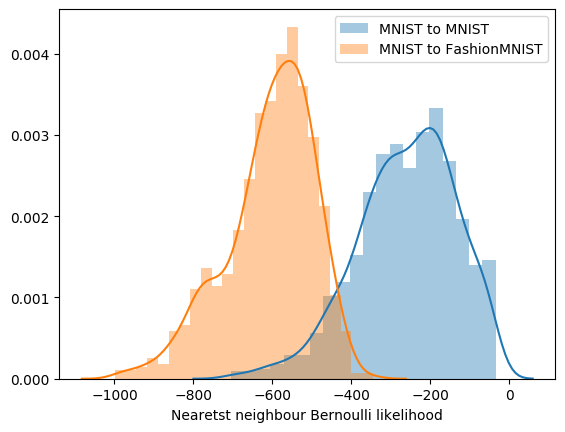

In [192]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train_mnist, ax=ax, label='MNIST to MNIST')
seaborn.distplot(nnd_test1_mnist, ax=ax, label='MNIST to FashionMNIST')
ax.set_xlabel('Nearetst neighbour Bernoulli likelihood')
ax.legend()
fig.savefig(output_dir + '/DataDistance_MNIST-FashionMNIST' + plot_ext, bbox_inches='tight')

In [193]:
n_samples = 1000
train = fashion_mnist_train_real.examples[:n_samples].reshape(-1, 784)
test1 = mnist_train_real.examples[:n_samples].reshape(-1, 784)
nnd_train_fashion = nearest_neighbour_distance_bernoulli(x=train, p=train, ignore_diag=True)
nnd_test1_fashion = nearest_neighbour_distance_bernoulli(x=test1, p=train, ignore_diag=False)

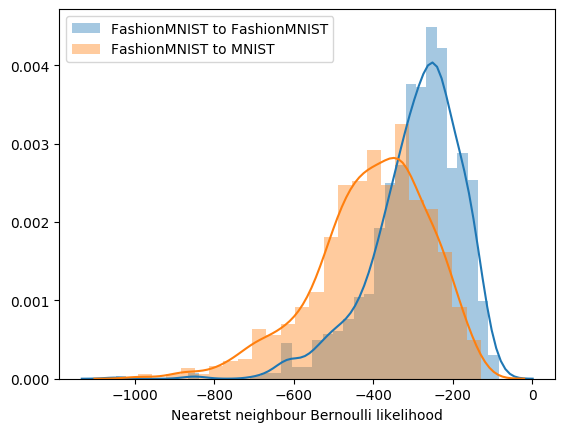

In [194]:
fig, ax = plt.subplots(1, 1)
seaborn.distplot(nnd_train_fashion, ax=ax, label='FashionMNIST to FashionMNIST')
seaborn.distplot(nnd_test1_fashion, ax=ax, label='FashionMNIST to MNIST')
ax.set_xlabel('Nearetst neighbour Bernoulli likelihood')
ax.legend()
fig.savefig(output_dir + '/DataDistance_FashionMNIST-MNIST' + plot_ext, bbox_inches='tight')

In the above we compute the summed Bernoulli likelihood of image $I$ from FashionMNIST when the pixels of image $J$ from MNIST is used as the true probabilities for all $I$ and $J$ (really a subsample). We choose the largest of these likelihoods for each of the $J$ images and plot the distribution. We also compute this for MNIST under MNIST. Finally, we repeat this for MNIST VS FashionMNIST.

We see that the distance to MNIST under FashionMNIST pixel probabilities is smaller than the difference to FashionMNIST under MNIST pixel probabilities. 

That is, MNIST is "contained within" FashionMNIST. This is to be understood as MNIST activating fewer pixels and activating them less on average than FashionMNIST does.

Nalisnick claims to be able to detect FashionMNIST as OOD when training on MNIST. Also, MNIST has higher likelihoods than FashionMNIST when training on FashionMNIST. This is the same assymmetry as observed in the plots above.

However, from the plots above it is clear that MNIST is not "enough within" FashionMNIST to cause MNIST to be more likely than FashionMNIST itself when evaluated under FashionMNIST pixel probabilities. This serves to show that the only way to ascribe MNIST higher likelihood than FashionMNIST when training on FashionMNIST is due to poor modelling.

## Load models

In [16]:
def get_data(train_data):
    if train_data == 'MNISTBinarized':
        x_train = mnist_train.examples.reshape(-1, 784)
        x_test1 = mnist_test1.examples.reshape(-1, 784)
        x_test2 = fashion_mnist_test1.examples.reshape(-1, 784)
        y_train = mnist_train.labels.argmax(axis=1)
        y_test1 = mnist_test1.labels.argmax(axis=1)
        y_test2 = fashion_mnist_test1.labels.argmax(axis=1)
    elif train_data == 'FashionMNISTBinarized':
        x_train = fashion_mnist_train.examples.reshape(-1, 784)
        x_test1 = fashion_mnist_test1.examples.reshape(-1, 784)
        x_test2 = mnist_test1.examples.reshape(-1, 784)
        y_train = fashion_mnist_train.labels.argmax(axis=1)
        y_test1 = fashion_mnist_test1.labels.argmax(axis=1)
        y_test2 = mnist_test1.labels.argmax(axis=1)
    return x_train, x_test1, x_test2, y_train, y_test1, y_test2

In [100]:
def load_models(run_ids):
    models = dict()
    for model_abbr, run_id in run_ids.items():
        run_id = str(run_id)

        model = vari.models.HierarchicalVariationalAutoencoder
        # Load the saved kwargs
        kwargs = torch.load(
            os.path.join(experiments_dir, run_id, 'model_kwargs.pkl'),
            map_location=torch.device('cpu')
        )
        model = model(**kwargs)

        try:
            model.load_state_dict(torch.load(
                os.path.join(experiments_dir, run_id, 'model_state_dict.pkl'),
                map_location=torch.device('cpu')
            ))
            models[model_abbr] = model
            print(f'Loaded ID {run_id} {model_abbr.upper()} ')
        except Exception as exc:
            print(f'Failed loading {model_abbr.upper()} ID {run_id}')
            print(exc)
            models[model_abbr] = None
    return models

In [101]:
print('mnist')
models_mnist = load_models(run_ids_mnist)
print('fashion_mnist')
models_fashion_mnist = load_models(run_ids_fashion_mnist)

Moons
Loaded ID 6853 1L FIXED 1 1IS Σ=0.01 
Loaded ID 6854 2L FIXED 1 1IS Σ=0.01 
Loaded ID 6813 1L FIXED 0.1 1IS Σ=0.01 
Loaded ID 6815 2L FIXED 0.1 1IS Σ=0.01 
Loaded ID 6849 1L FIXED 0.01 1IS Σ=0.01 
Loaded ID 6848 2L FIXED 0.01 1IS Σ=0.01 
Loaded ID 6867 1L FIXED 0.01 100IS Σ=0.01 
Loaded ID 6866 2L FIXED 0.01 100IS Σ=0.01 
Spirals
Loaded ID 6619 VAE1L 
Loaded ID 6625 VAE3L 


## Visualize latent space

In [95]:
constant_cmap = get_constant_colormap((0.2, 0.2, 0.2))

def plot_vectors_and_mesh(vectors, mesh=None, fig=None, ax=None, figsize=(20, 20), color='C0', alpha=0.4, label='train', label_ids=None):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    
    if mesh is not None:
        ax.plot(mesh[:,0], mesh[:,1], c='black', alpha=.2, linewidth=.5)
        ax.scatter(mesh[:,0], mesh[:,1], c=[(.8, .8, .8, .8)], alpha=.5, s=5.)
    if label_ids is not None:
        for i in np.unique(label_ids):
            ax.scatter(vectors[label_ids==i, 0], vectors[label_ids==i, 1], c=f'C{i}', alpha=alpha, label=f"{label}:class{i}")
    else:
        ax.scatter(vectors[:,0], vectors[:,1], c=color, alpha=alpha, label=label)
    #ax1.scatter(vae_qz_mu_x2[:,0], vae_qz_mu_x2[:,1], c=[test1_0], alpha=0.4, label="test1")
    # ax1.axis('off')
    ax.legend()
    return fig, ax

### mnist

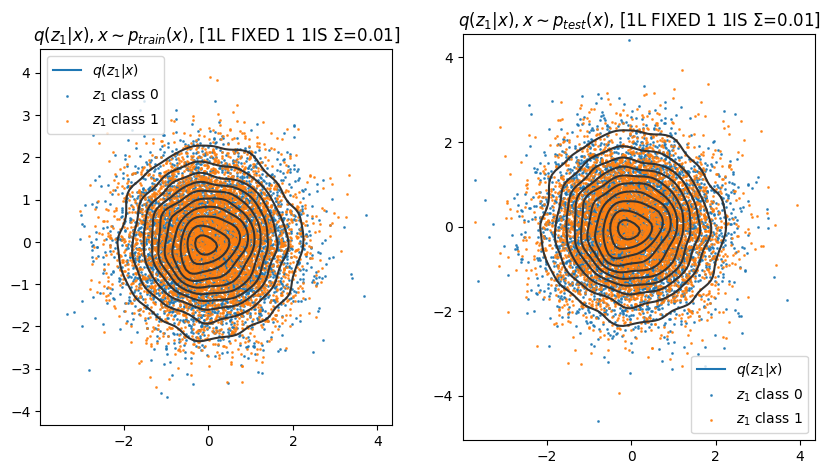

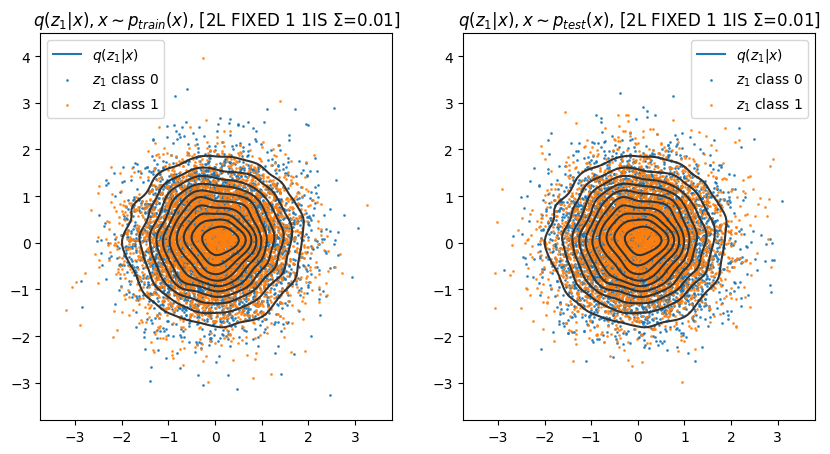

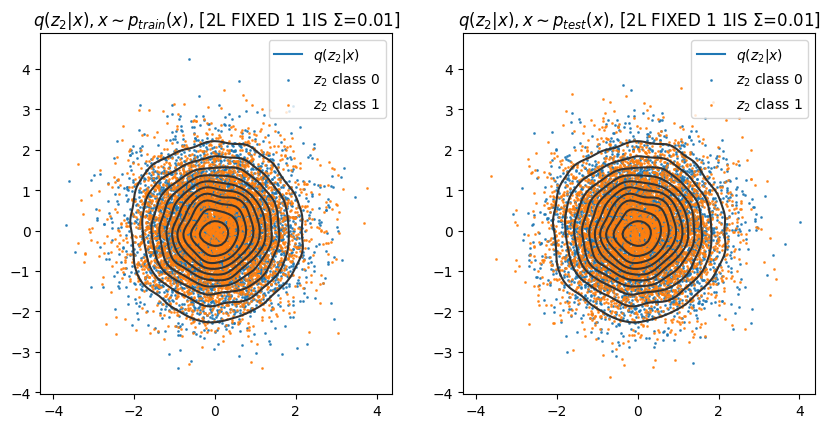

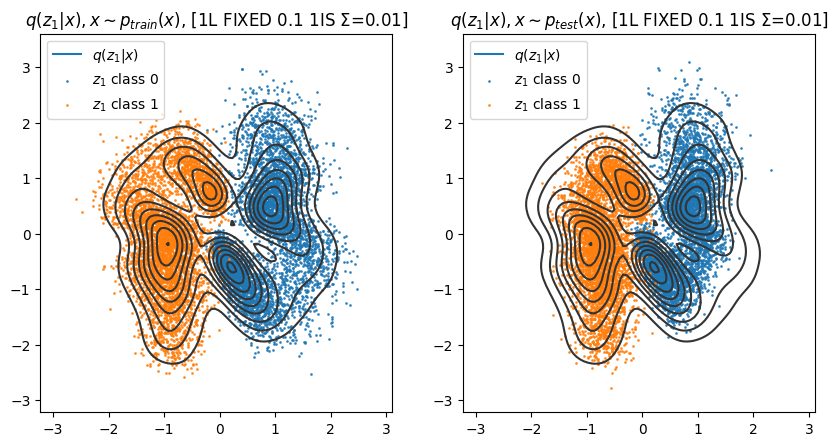

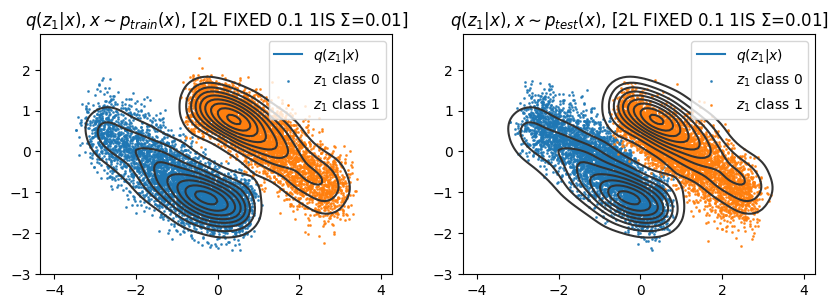

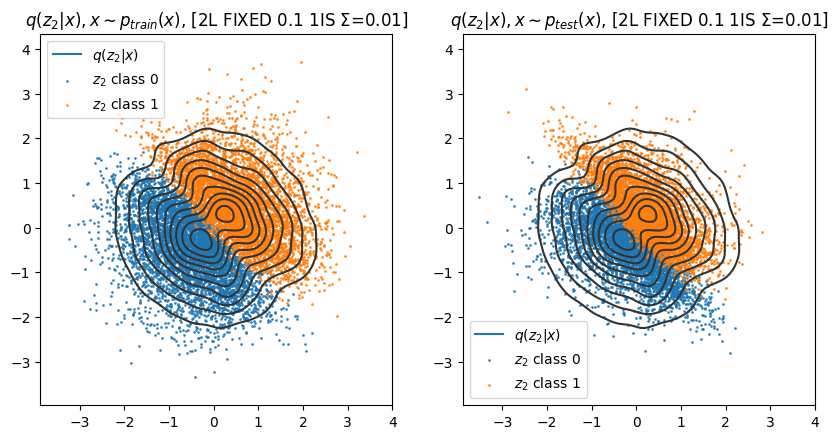

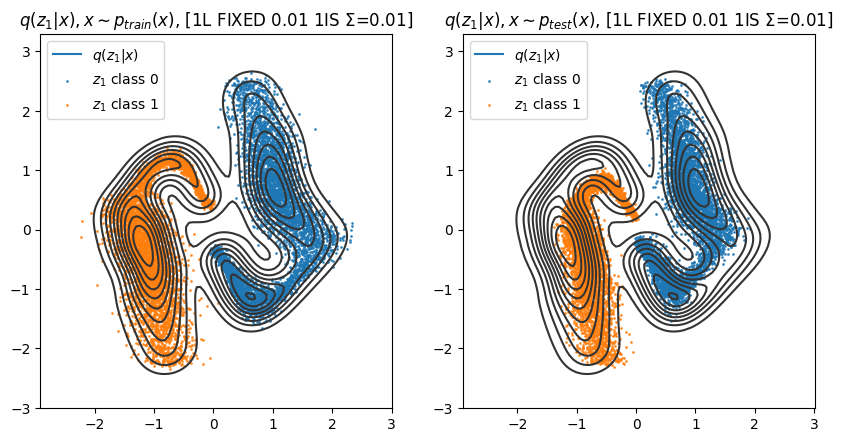

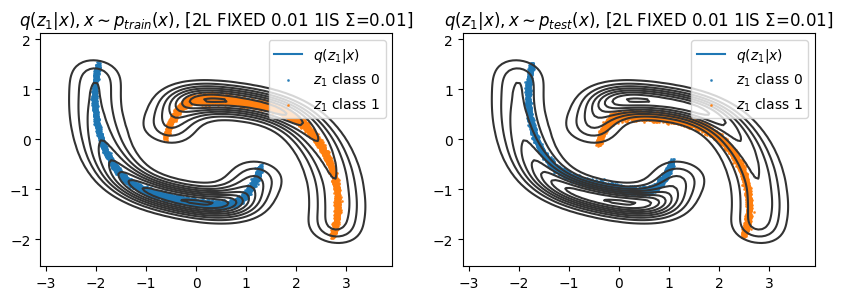

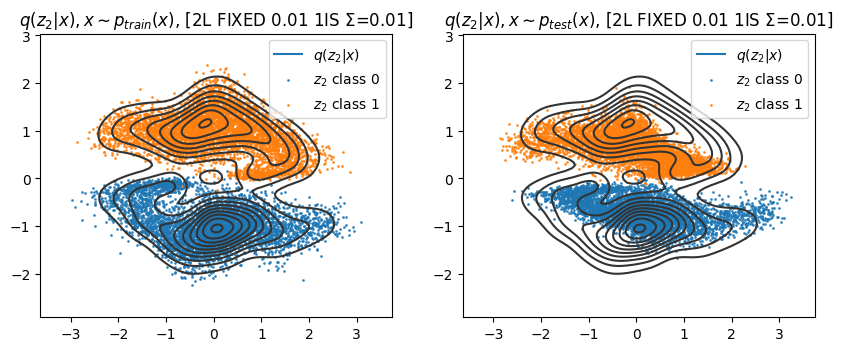

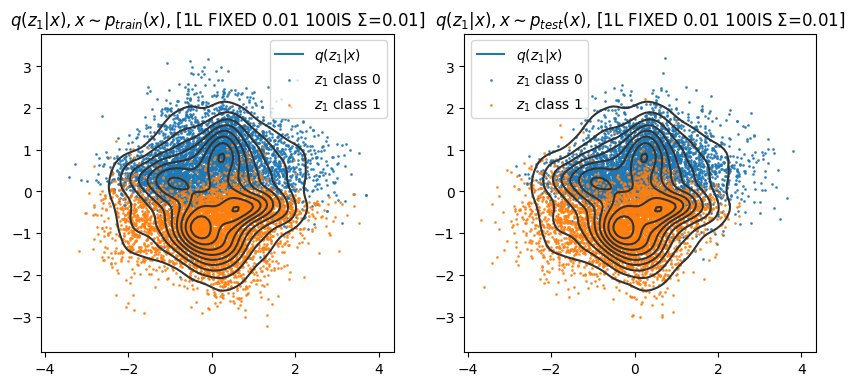

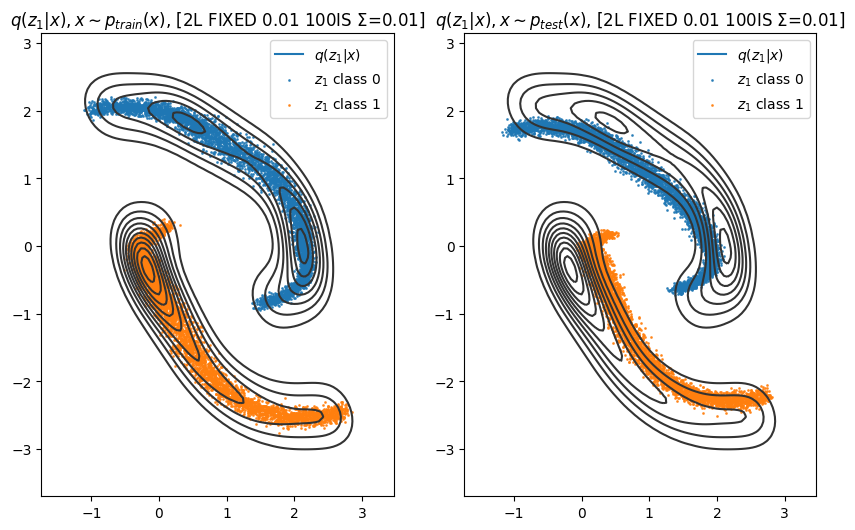

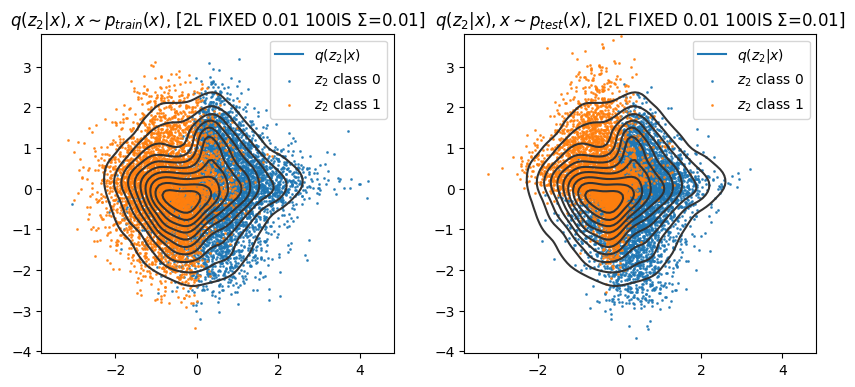

In [111]:
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('MNISTBinarized')
for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze()
        qz_mu_train = latents_train[name][1].mean.squeeze()

        qz_test1 = latents_test1[name][0].squeeze()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        
        ax1.set_title(f'$q(z_{i_layer}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            ax1.scatter(qz_train[y_train==c, 0].numpy(),
                        qz_train[y_train==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax1)
        ax1.set_aspect('equal')
        ax1.legend()
        
        ax2.set_title(f'$q(z_{i_layer}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            ax2.scatter(qz_test1[y_test1==c, 0].numpy(),
                        qz_test1[y_test1==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax2)
        ax2.set_aspect('equal')
        ax2.legend()

### fashion_mnist

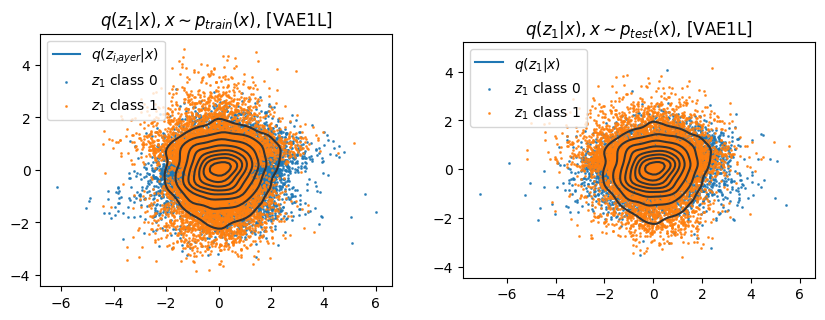

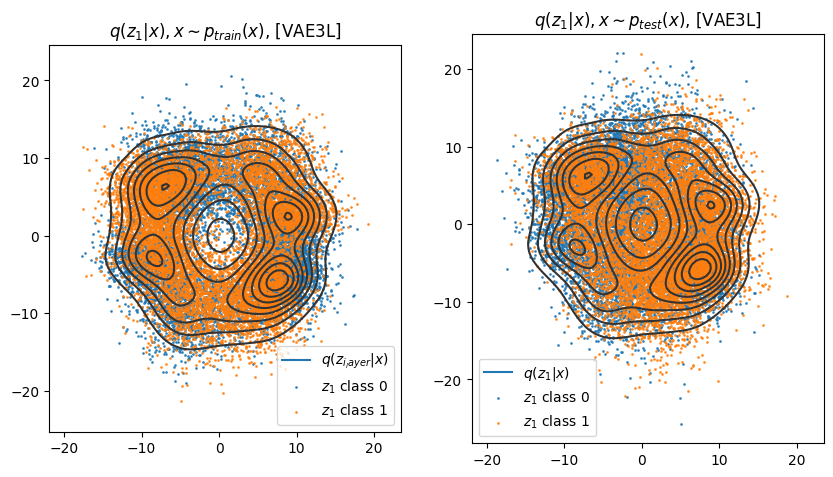

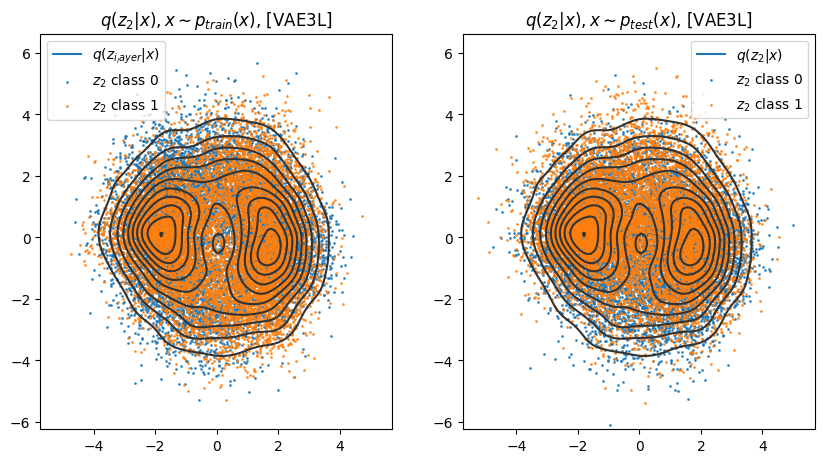

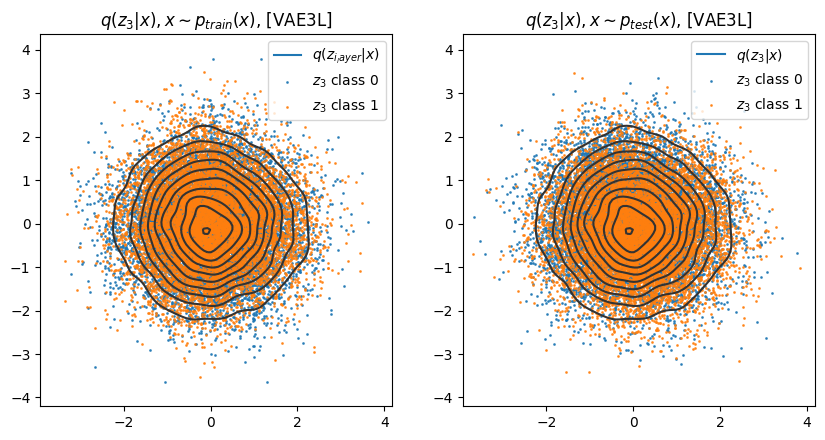

In [19]:
x_train, x_test1, x_test2, y_train, y_test1, y_test2 = get_data('FashionMNISTBinarized')
for abbr, model in models.items():
    with torch.no_grad():
        latents_train = model.encode(torch.FloatTensor(x_train))
        latents_test1 = model.encode(torch.FloatTensor(x_test1))

    for i_layer, name in enumerate(latents_train.keys(), start=1):
        qz_train = latents_train[name][0].squeeze()
        qz_mu_train = latents_train[name][1].mean.squeeze()

        qz_test1 = latents_test1[name][0].squeeze()
        qz_mu_test1 = latents_test1[name][1].mean.squeeze()

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
        
        ax1.set_title(f'$q(z_{i_layer}|x), x\sim p_{{train}}(x)$, [{abbr.upper()}]')
        for c in set(y_train):
            ax1.scatter(qz_train[y_train==c, 0].numpy(),
                        qz_train[y_train==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax1)
        ax1.set_aspect('equal')
        ax1.legend()
        
        ax2.set_title(f'$q(z_{i_layer}|x), x\sim p_{{test}}(x)$, [{abbr.upper()}]')
        for c in set(y_test1):
            ax2.scatter(qz_test1[y_test1==c, 0].numpy(),
                        qz_test1[y_test1==c, 1].numpy(),
                        marker='o', s=1, alpha=0.8, color=f'C{c}', label=f'$z_{i_layer}$ class {c}')
        seaborn.kdeplot(qz_train[:, 0].numpy(),
                        qz_train[:, 1].numpy(),
                        shade=False, cmap=constant_cmap, label=f'$q(z_{i_layer}|x)$', ax=ax2)
        ax2.set_aspect('equal')
        ax2.legend()

## Visualize reconstruction

AxesSubplot(0.125,0.712609;0.352273x0.167391) 1L Fixed 1 1IS σ=0.01
AxesSubplot(0.547727,0.712609;0.352273x0.167391) 2L Fixed 1 1IS σ=0.01
AxesSubplot(0.125,0.511739;0.352273x0.167391) 1L Fixed 0.1 1IS σ=0.01
AxesSubplot(0.547727,0.511739;0.352273x0.167391) 2L Fixed 0.1 1IS σ=0.01
AxesSubplot(0.125,0.31087;0.352273x0.167391) 1L Fixed 0.01 1IS σ=0.01
AxesSubplot(0.547727,0.31087;0.352273x0.167391) 2L Fixed 0.01 1IS σ=0.01
AxesSubplot(0.125,0.11;0.352273x0.167391) 1L Fixed 0.01 100IS σ=0.01
AxesSubplot(0.547727,0.11;0.352273x0.167391) 2L Fixed 0.01 100IS σ=0.01


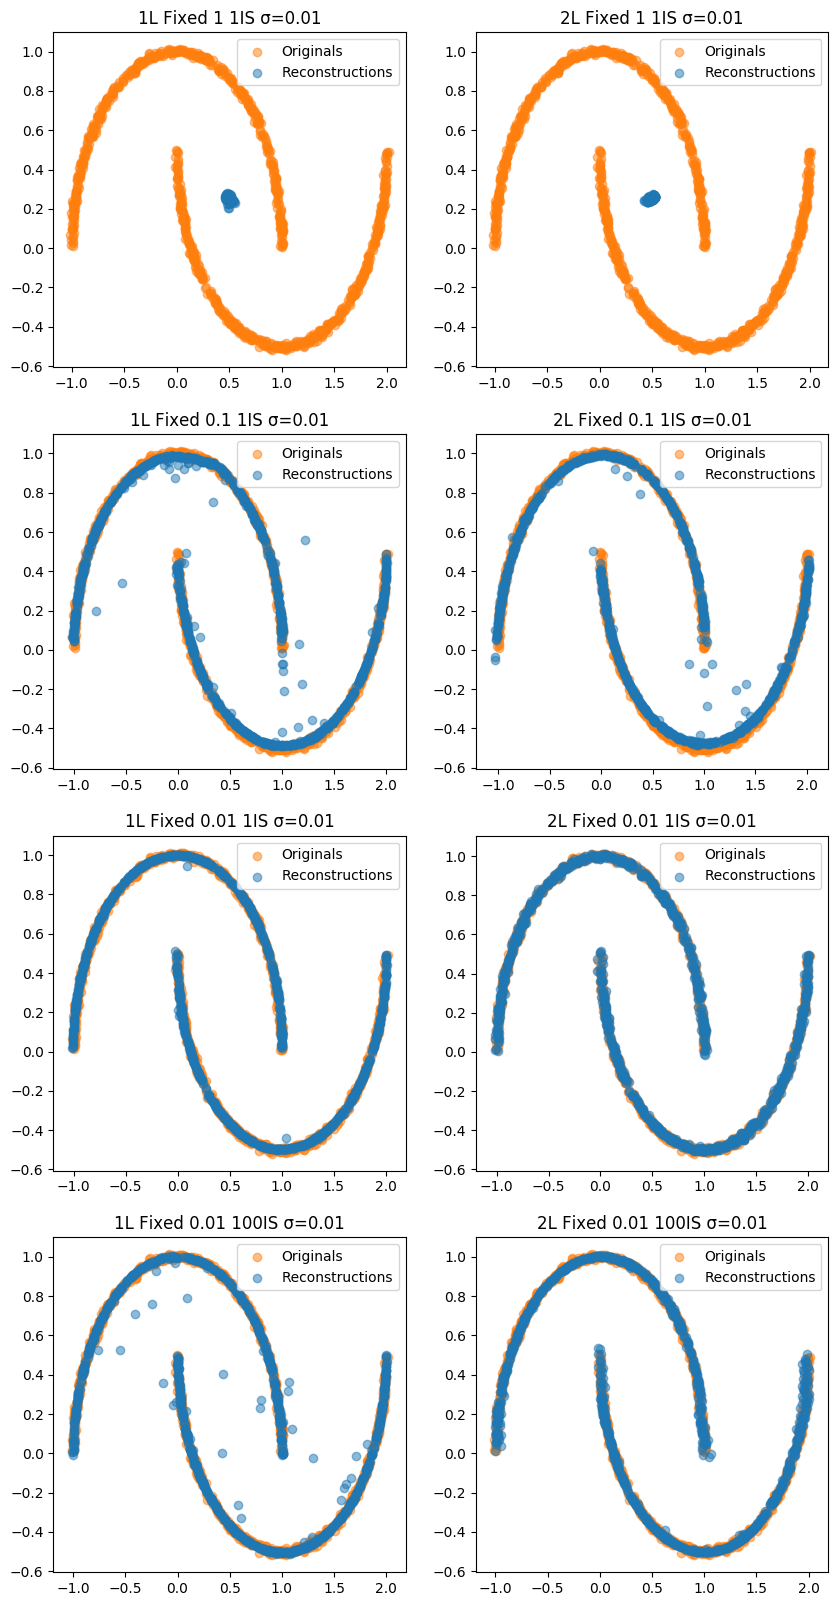

In [114]:
dataset = mnist
models = models_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    print(ax, abbr)
    x_originals = torch.FloatTensor(x_train[:n_samples, :])
    with torch.no_grad():
        px_reconstructions = model(x_originals)
        
    plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_reconstructions.mean.squeeze(), alpha=0.5, label='Reconstructions', ax=ax)
    ax.set_title(abbr)

AxesSubplot(0.125,0.712609;0.352273x0.167391) 1L 1IS σ=0.00
AxesSubplot(0.547727,0.712609;0.352273x0.167391) 2L 1IS σ=0.00
AxesSubplot(0.125,0.511739;0.352273x0.167391) 1L Fixed 0.1 1IS σ=0.00
AxesSubplot(0.547727,0.511739;0.352273x0.167391) 2L Fixed 0.1 1IS σ=0.00
AxesSubplot(0.125,0.31087;0.352273x0.167391) 1L Fixed 0.1 1IS σ=0.01
AxesSubplot(0.547727,0.31087;0.352273x0.167391) 2L Fixed 0.1 1IS σ=0.01
AxesSubplot(0.125,0.11;0.352273x0.167391) 1L Fixed 0.01 1IS σ=0.01
AxesSubplot(0.547727,0.11;0.352273x0.167391) 2L Fixed 0.01 1IS σ=0.01


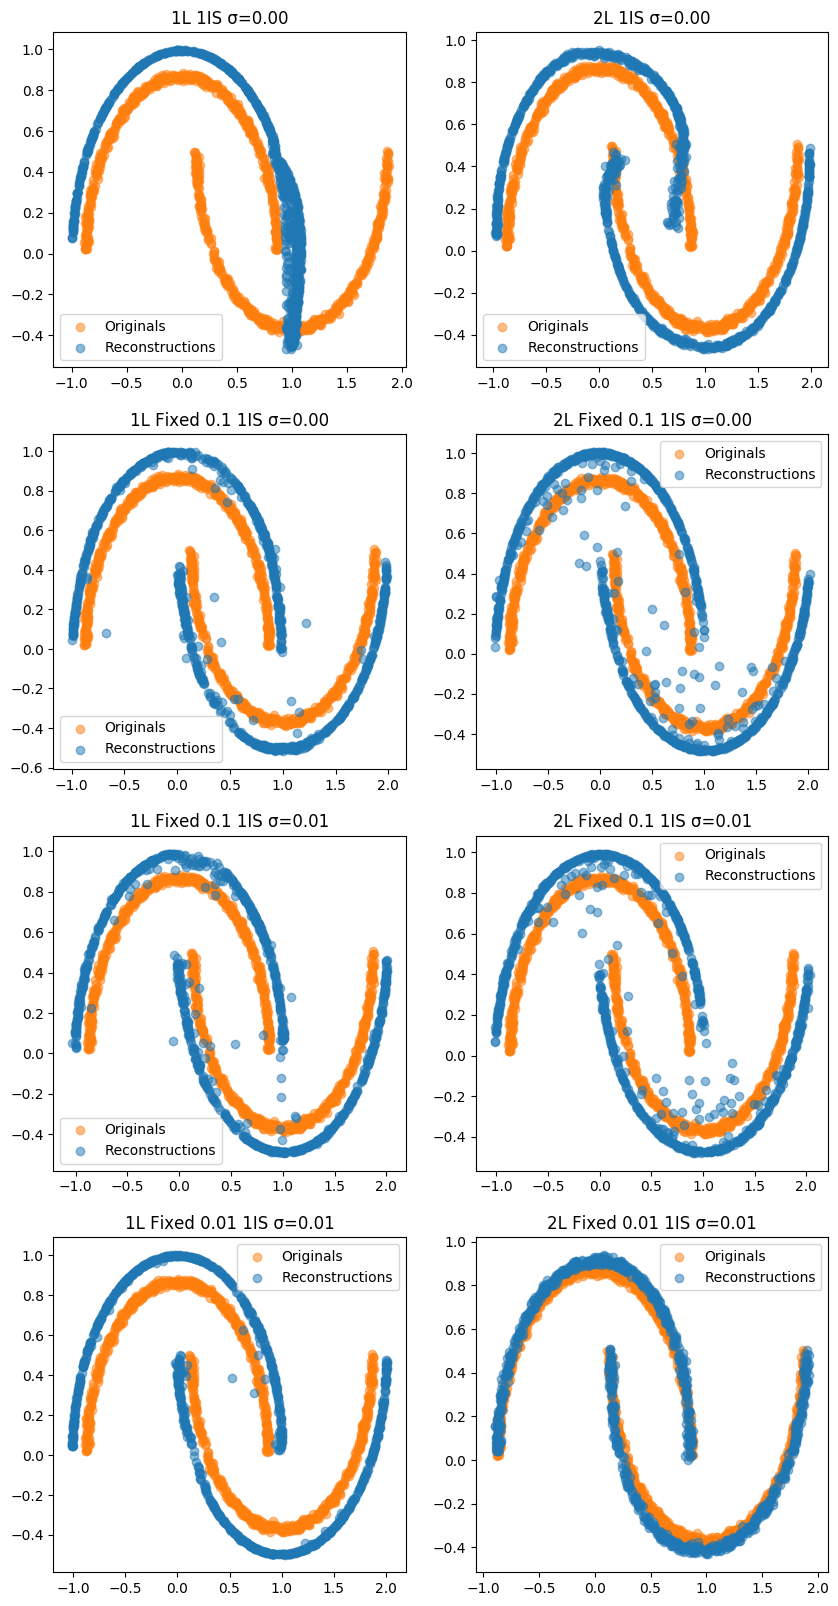

In [65]:
dataset = mnist
models = models_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    print(ax, abbr)
    x_originals = torch.FloatTensor(x_test1[:n_samples, :])
    with torch.no_grad():
        px_reconstructions = model(x_originals)
        
    plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_reconstructions.mean.squeeze(), alpha=0.5, label='Reconstructions', ax=ax)
    ax.set_title(abbr)

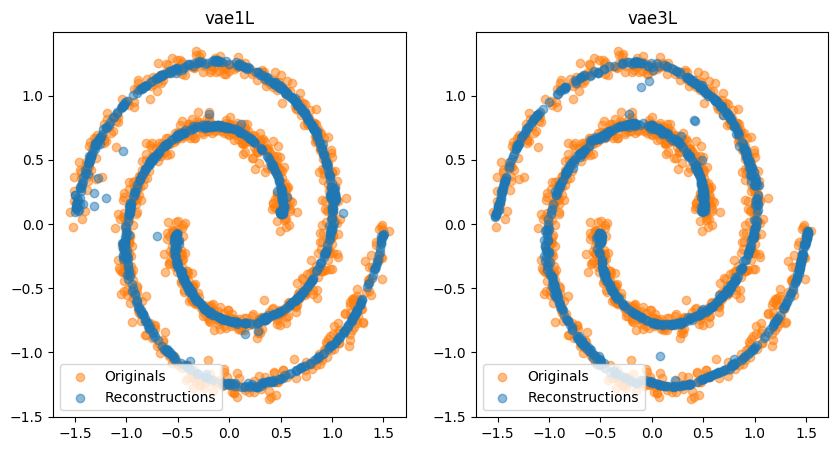

In [37]:
dataset = fashion_mnist
models = models_fashion_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    x_originals = torch.FloatTensor(x_train[:n_samples, :])
    with torch.no_grad():
        px_reconstructions = model(x_originals)
        
    plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_reconstructions.mean.squeeze(), alpha=0.5, label='Reconstructions', ax=ax)
    ax.set_title(abbr)

## Visualize sampling

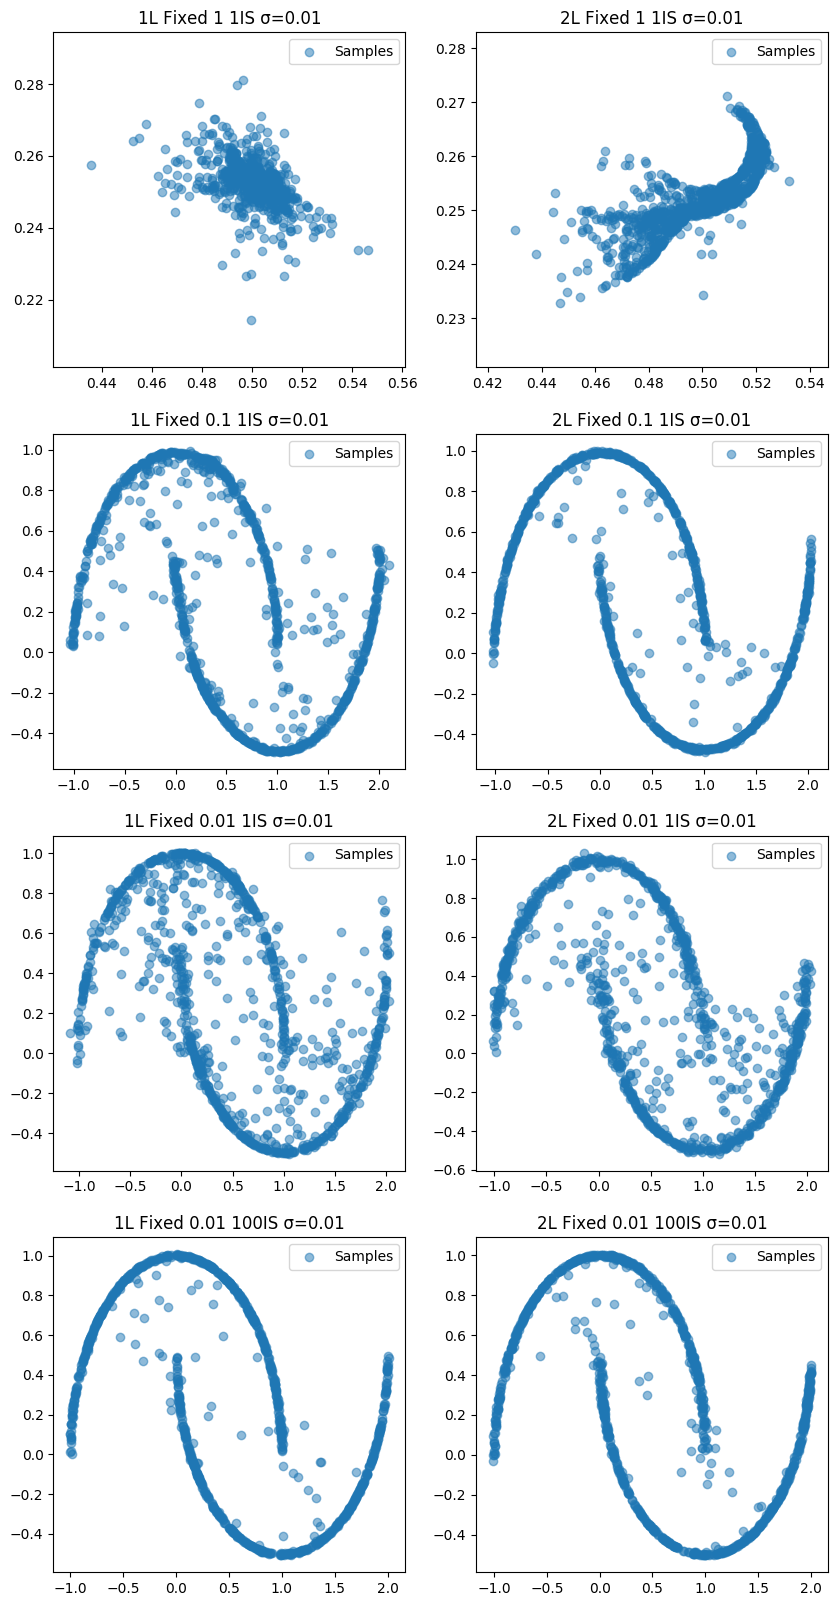

In [115]:
dataset = mnist
models = models_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 1000
p_z_samples = torch.randn((n_samples, 2))

n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5*n_rows))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    #x_originals = torch.FloatTensor(x_test1[:n_samples, :])
    
    with torch.no_grad():
        px_samples = model.generate(z=p_z_samples)
        
    #plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_samples.mean.squeeze(), alpha=0.5, label='Samples', ax=ax)
    #seaborn.kdeplot(px_samples.mean.squeeze())
    ax.set_title(abbr)

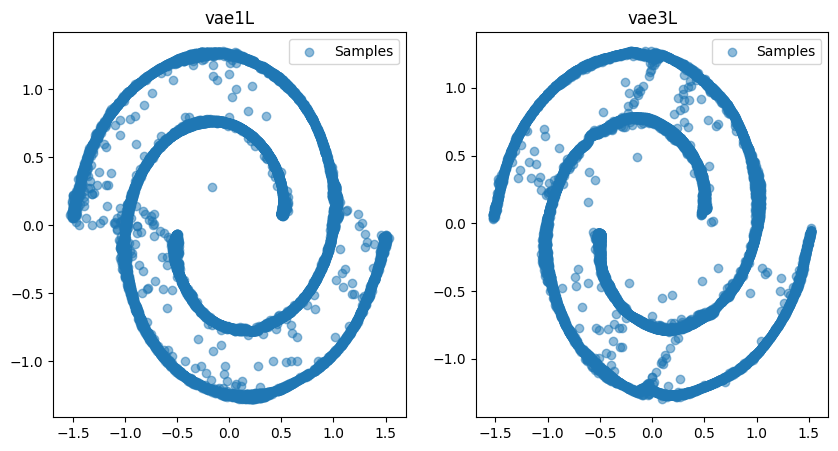

In [999]:
dataset = fashion_mnist
models = models_fashion_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
meshgrid = dataset['meshgrid']

n_samples = 10000
p_z_samples = torch.randn((n_samples, 2))

n_rows = (len(models) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5))
if n_rows > 1:
    axes = [ax for sub in axes for ax in sub]
for ax, (abbr, model) in zip(axes, models.items()):
    #x_originals = torch.FloatTensor(x_train[:n_samples, :])

    with torch.no_grad():
        px_samples = model.generate(z=p_z_samples)
        
    #plot_vectors_and_mesh(x_originals, alpha=0.5, color='C1', label='Originals', ax=ax)
    plot_vectors_and_mesh(px_samples.mean.squeeze(), alpha=0.5, label='Samples', ax=ax)
    ax.set_title(abbr)

## Visualize ELBO

In [238]:
def compute_elbo_grid(model, x_lim, y_lim, importance_samples=10, zoom=0, nx=500, ny=500):
    (x_min, x_max), (y_min, y_max) = x_lim, y_lim
    x = np.linspace(x_min - np.abs(x_min * zoom), x_max + np.abs(x_max * zoom), nx)
    y = np.linspace(y_min - np.abs(y_min * zoom), y_max + np.abs(y_max * zoom), ny)
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    zv = np.zeros(xv.shape)
    with torch.no_grad():
        for j in tqdm.tqdm(range(x.shape[0])):
            inp = np.append(xv[:, j:j+1], yv[:, j:j+1], axis=1)
            inp = torch.FloatTensor(inp)
            elbo, kl, likelihood = model.elbo(inp, importance_samples=importance_samples)
            zv[:, j] = elbo.flip(0)
    return zv

In [239]:
elbo_min_clip = -1000

In [240]:
model = models_mnist[list(models_mnist.keys())[0]]

vae_zv = dict()
vae_zv[1] = compute_elbo_grid(model, (x_min, x_max), (y_min, y_max), zoom=1, importance_samples=10)
vae_zv[10] = compute_elbo_grid(model, (x_min, x_max), (y_min, y_max), zoom=10, importance_samples=10)

100%|██████████| 500/500 [00:08<00:00, 57.22it/s]


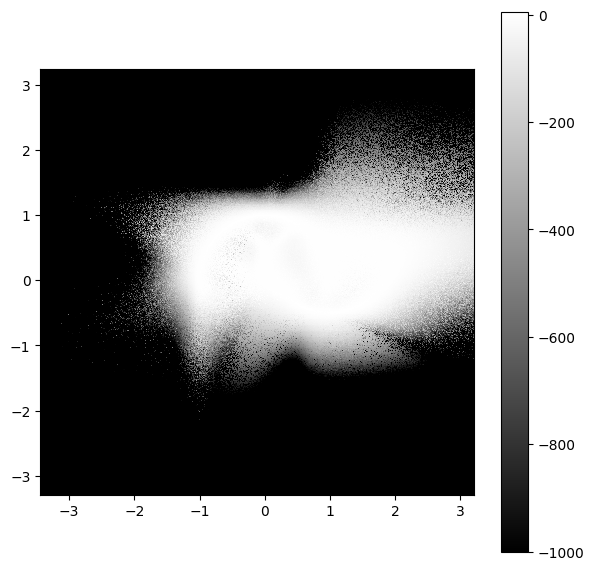

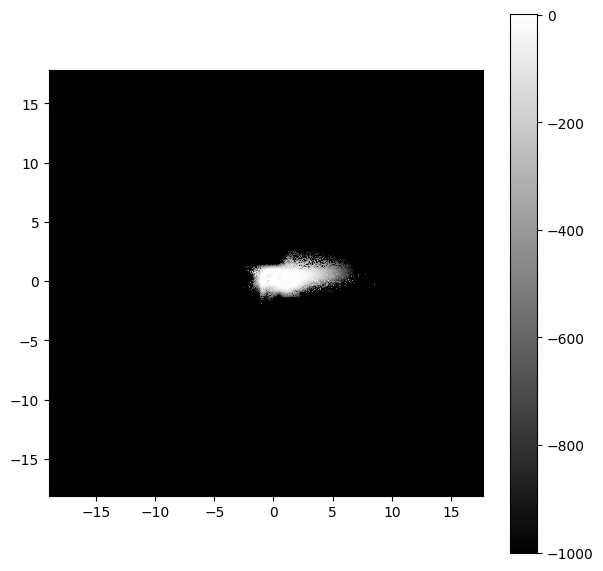

In [241]:
for zoom, zv in vae_zv.items():
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    plt.imshow(zv.clip(min=elbo_min_clip), mpl.cm.get_cmap('binary_r'), extent=(
        x_min - np.abs(x_min * zoom),
        x_max + np.abs(x_max * zoom),
        y_min - np.abs(y_min * zoom),
        y_max + np.abs(y_max * zoom)
    ))
    plt.colorbar()
    ax1.axis(aspect='image');

In [28]:
vae_zv = dict()
vae_zv[1] = compute_elbo_grid(models_mnist['vae2L'], (x_min, x_max), (y_min, y_max), zoom=1, importance_samples=10)
vae_zv[10] = compute_elbo_grid(models_mnist['vae2L'], (x_min, x_max), (y_min, y_max), zoom=10, importance_samples=10)

100%|██████████| 500/500 [00:05<00:00, 91.16it/s] 


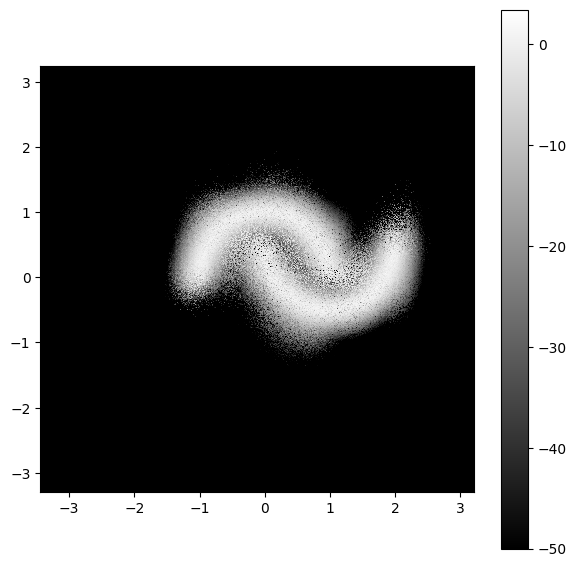

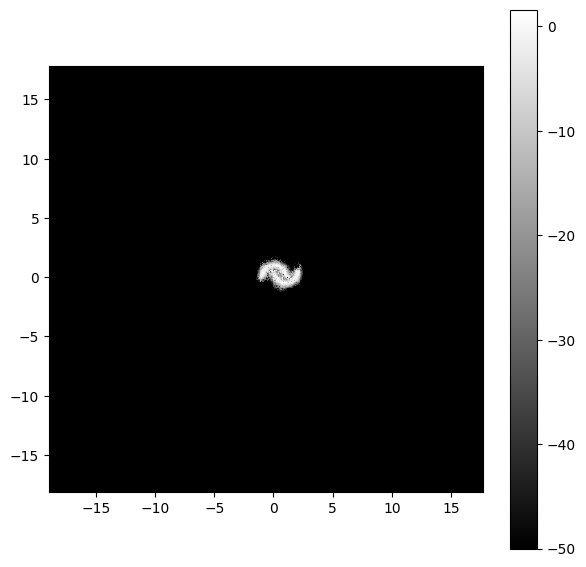

In [29]:
for zoom, zv in vae_zv.items():
    fig, ax1 = plt.subplots(1, 1, figsize=(7, 7))
    plt.imshow(zv.clip(min=elbo_min_clip), mpl.cm.get_cmap('binary_r'), extent=(
        x_min - np.abs(x_min * zoom),
        x_max + np.abs(x_max * zoom),
        y_min - np.abs(y_min * zoom),
        y_max + np.abs(y_max * zoom)
    ))
    plt.colorbar()
    ax1.axis(aspect='image');

## OOD detection based on ELBO

### mnist

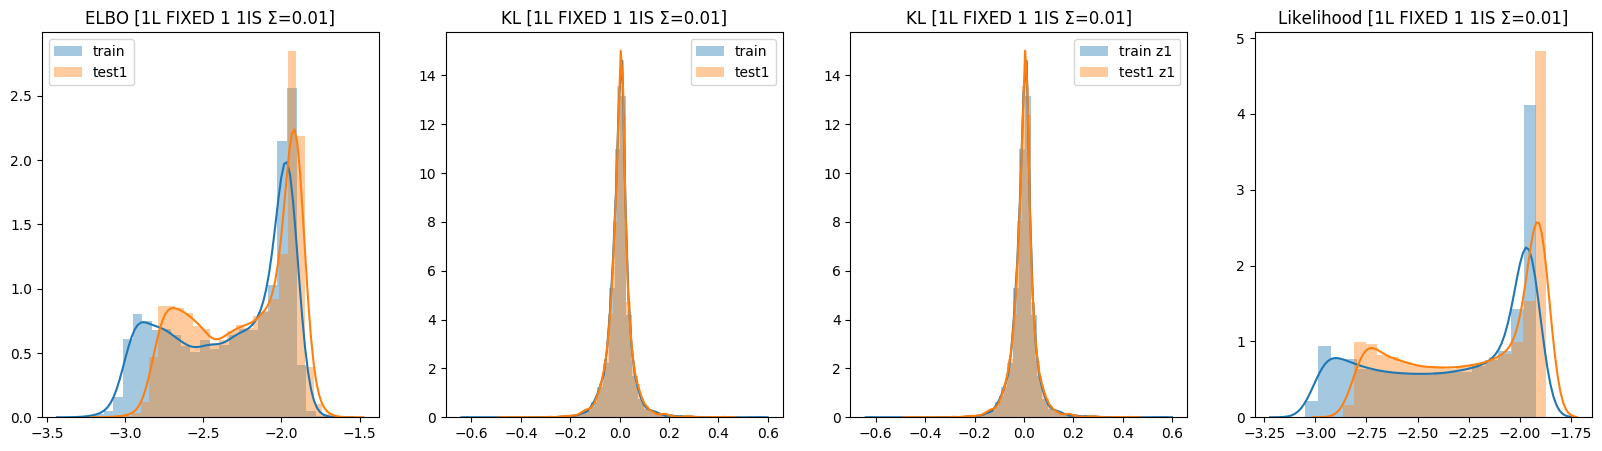

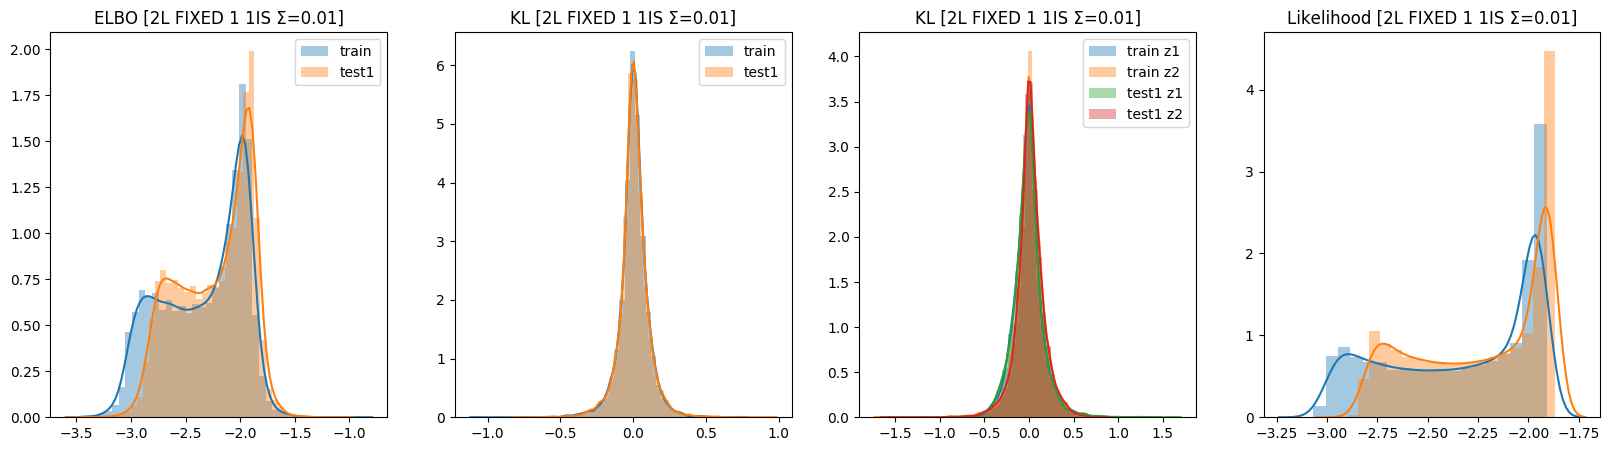

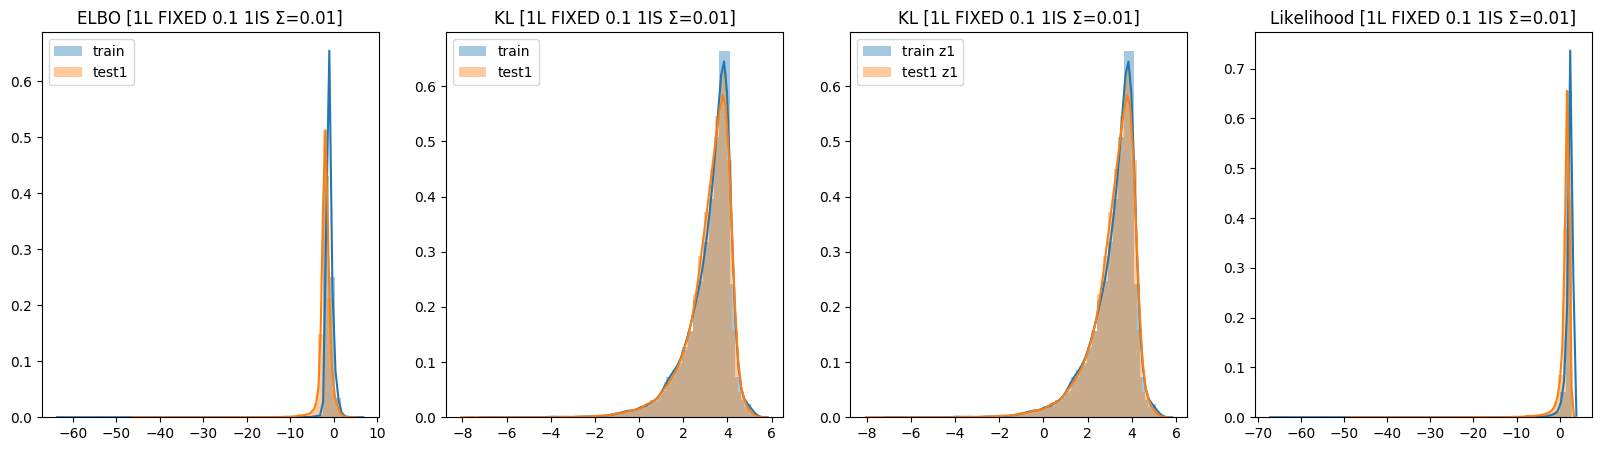

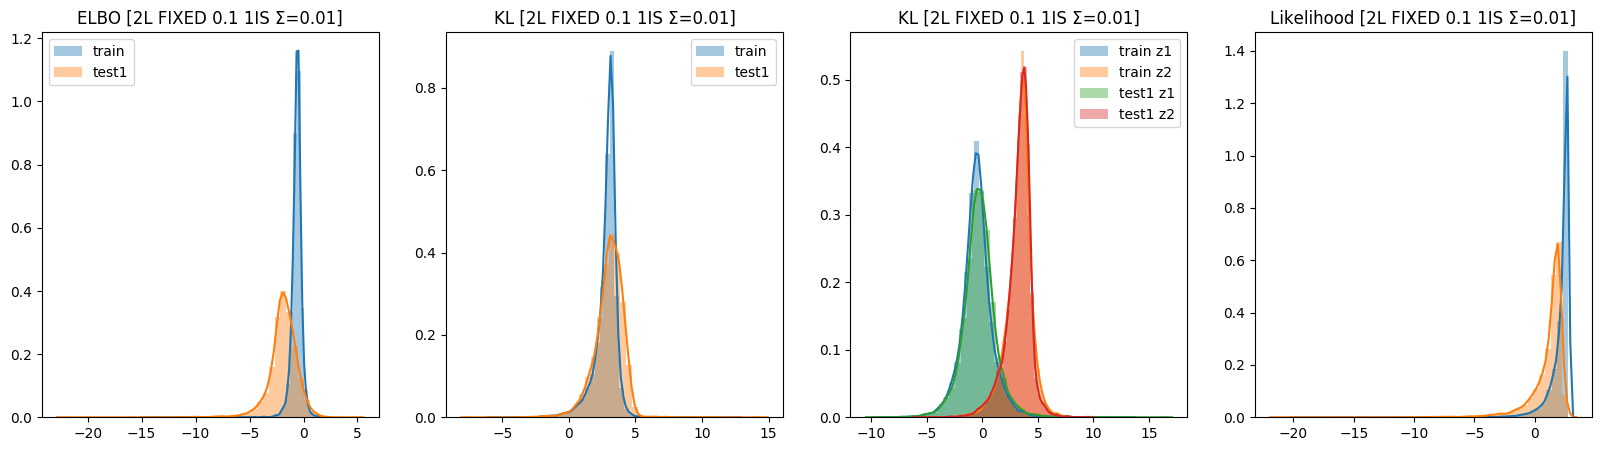

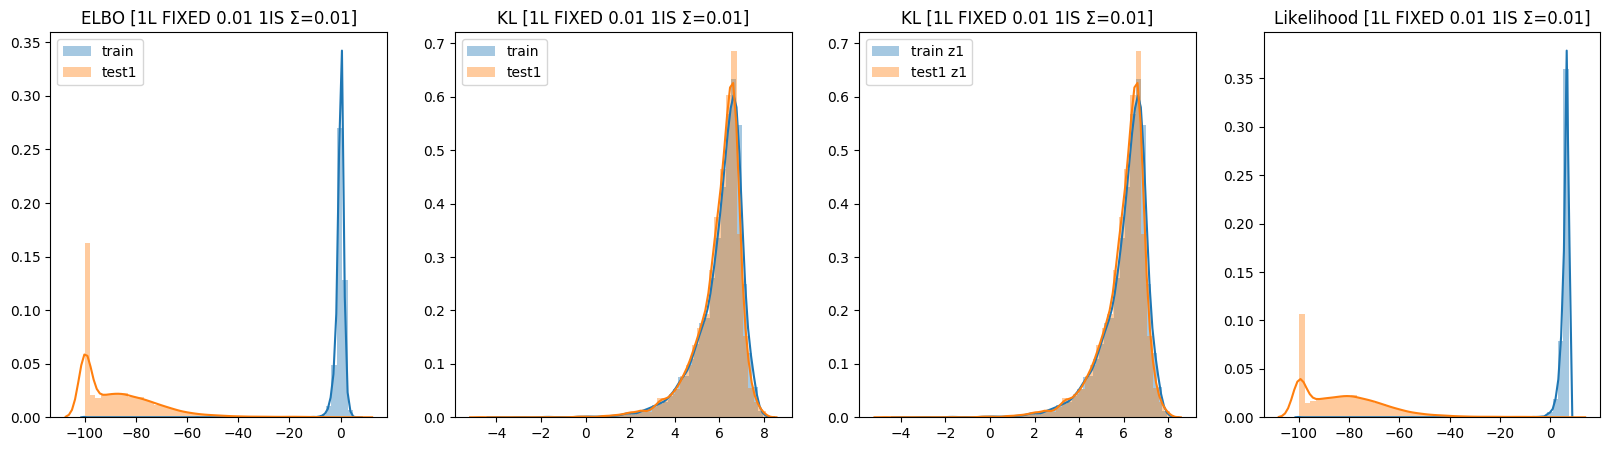

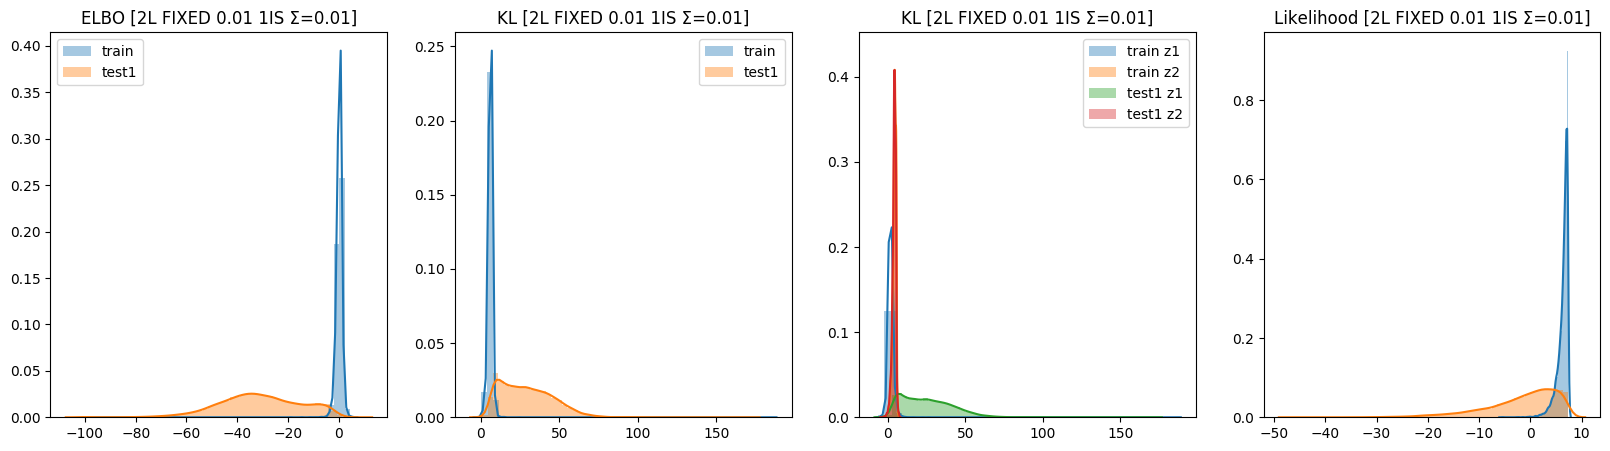

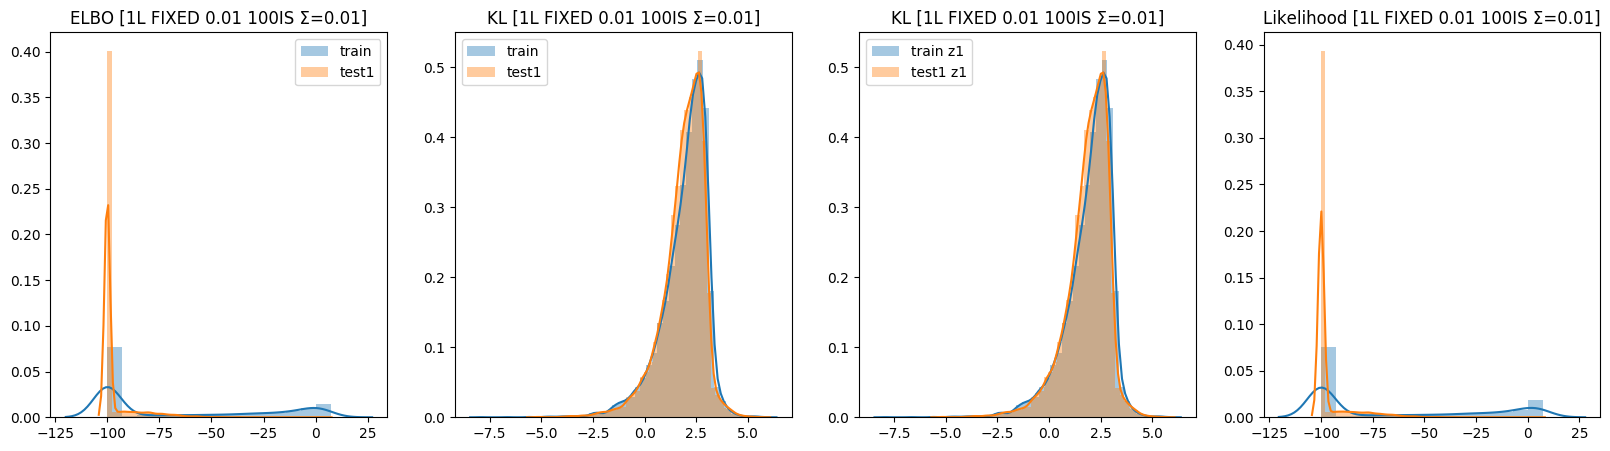

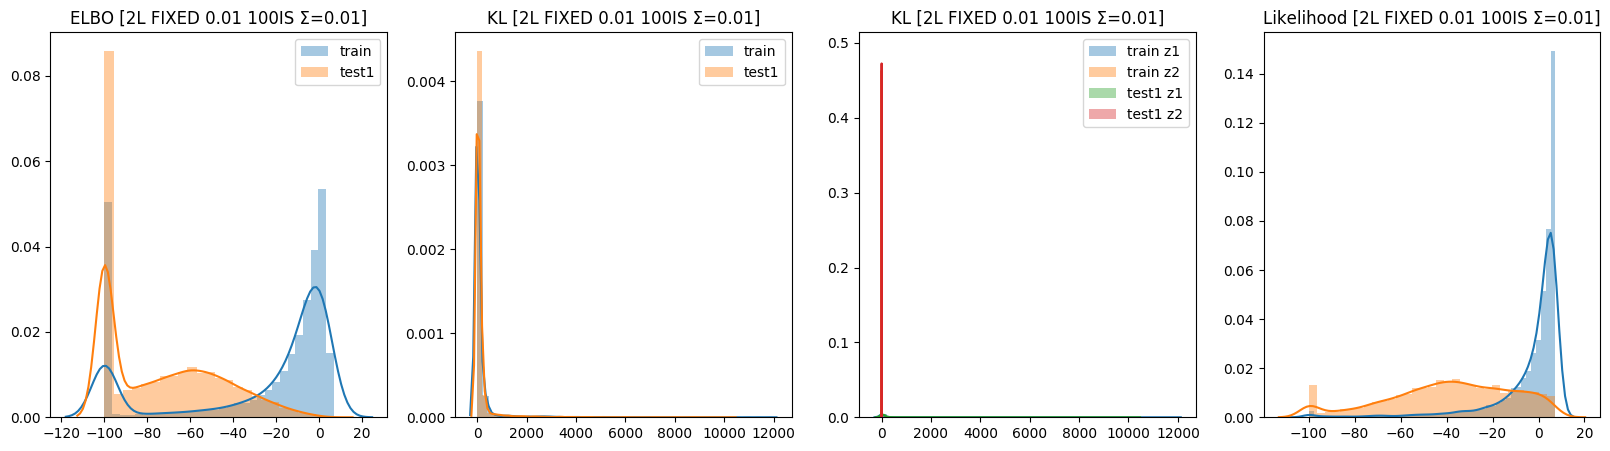

In [116]:
dataset = mnist
models = models_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=True, z2=True) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, likelihood_train, kl_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_train = model.kl_divergences
        elbo_test1, likelihood_test1, kl_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_test1 = model.kl_divergences
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train, kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1, kde_kws={}, ax=ax2, label='test1')
    
    for latent_key, kl in kls_train.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'train {latent_key}')
    for latent_key, kl in kls_test1.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'test1 {latent_key}')

    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax4, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax4, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'KL [{abbr.upper()}]')
    ax4.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

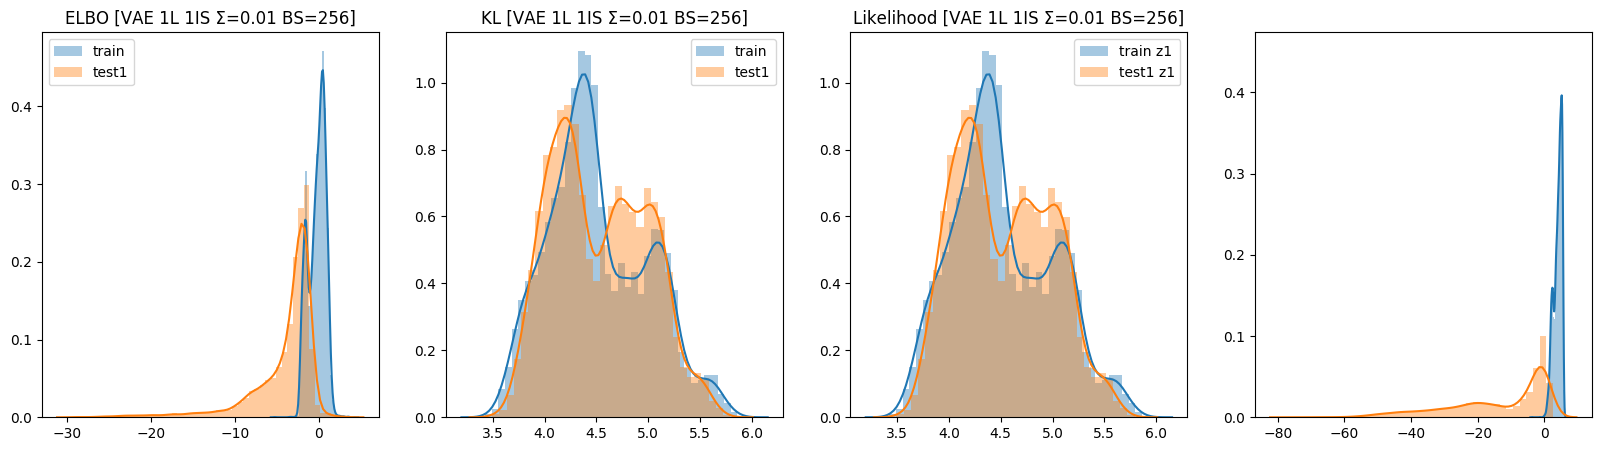

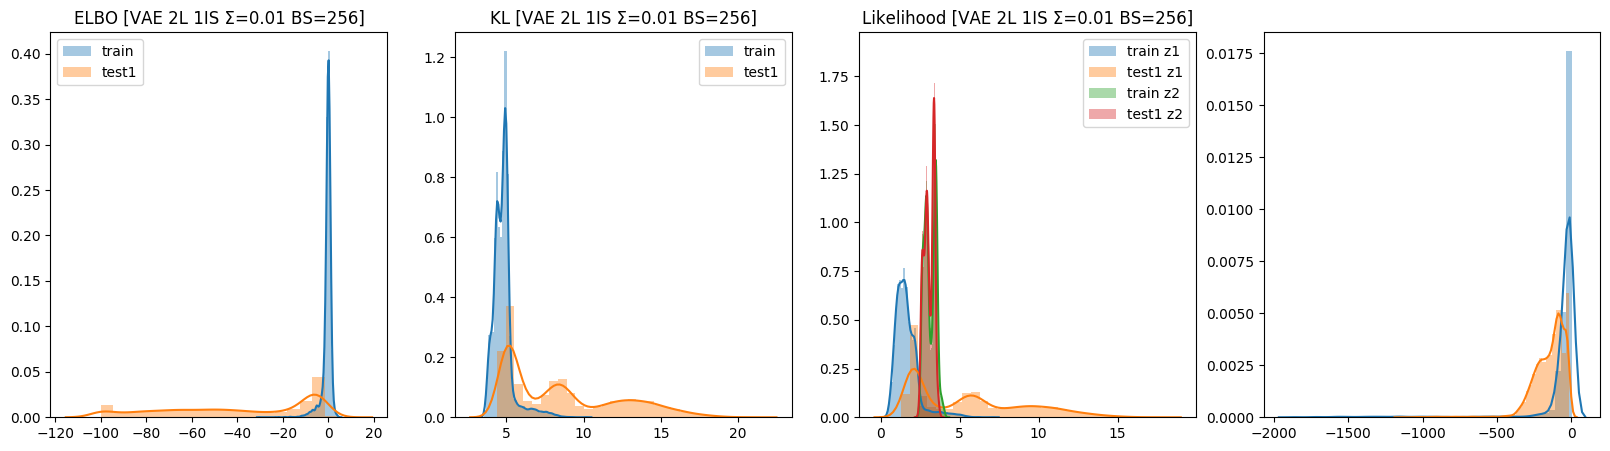

In [232]:
dataset = mnist
models = models_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=False, z2=True) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, likelihood_train, kl_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_train = model.kl_divergences
        elbo_test1, likelihood_test1, kl_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_test1 = model.kl_divergences
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train, kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1, kde_kws={}, ax=ax2, label='test1')
    
    for (latent_key, _kl_train), (_, _kl_test1) in zip(kls_train.items(), kls_test1.items()):
        seaborn.distplot(_kl_train, kde_kws={}, ax=ax3, label=f'train {latent_key}')
        seaborn.distplot(_kl_test1, kde_kws={}, ax=ax3, label=f'test1 {latent_key}')

    seaborn.distplot(likelihood_train.clamp(-10000), kde_kws={}, ax=ax4, label='train')
    seaborn.distplot(likelihood_test1.clamp(-10000), kde_kws={}, ax=ax4, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

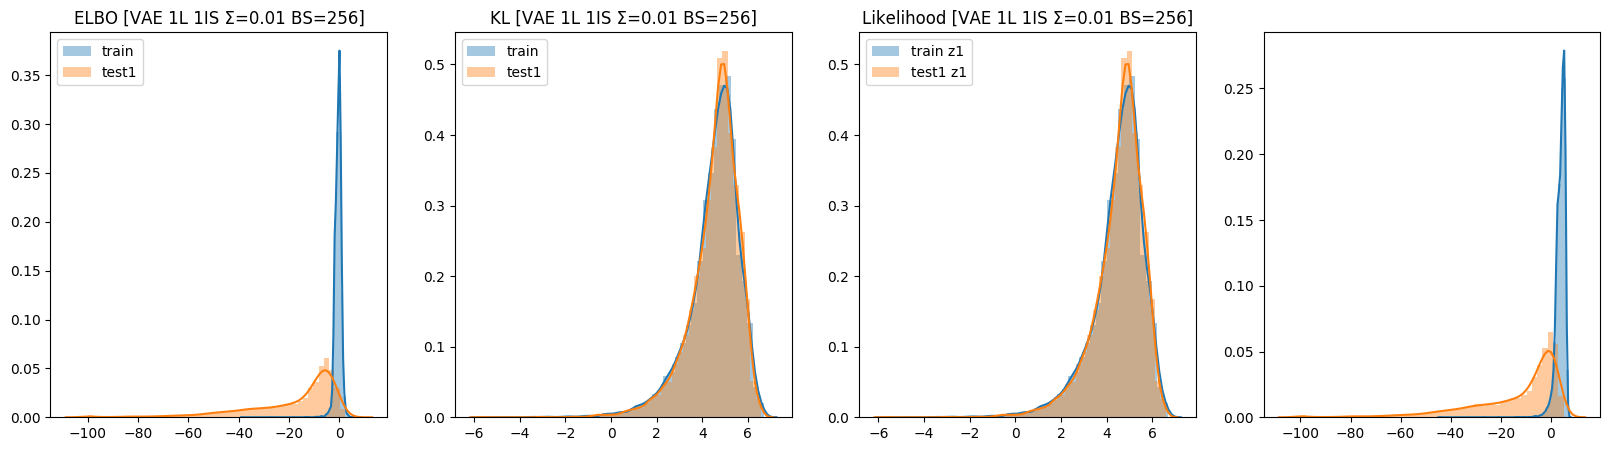

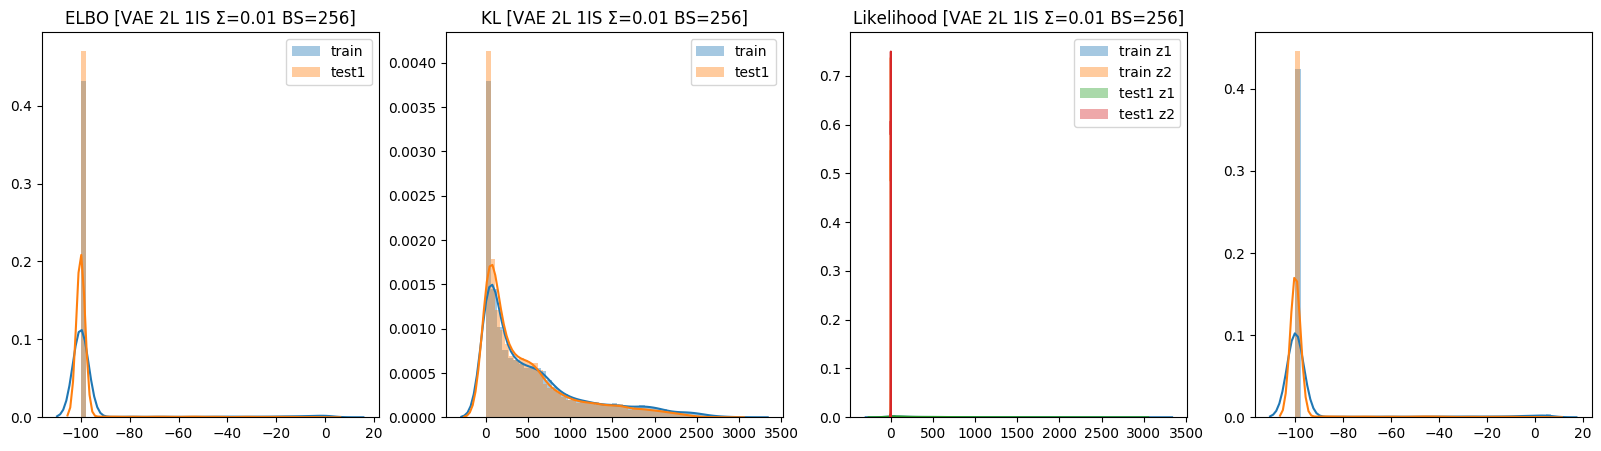

In [218]:
dataset = mnist
models = models_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=False, z2=False) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, likelihood_train, kl_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_train = model.kl_divergences
        elbo_test1, likelihood_test1, kl_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
        kls_test1 = model.kl_divergences
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train, kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1, kde_kws={}, ax=ax2, label='test1')
    
    for latent_key, kl in kls_train.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'train {latent_key}')
    for latent_key, kl in kls_test1.items():
        seaborn.distplot(kl, kde_kws={}, ax=ax3, label=f'test1 {latent_key}')

    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax4, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax4, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

### fashion_mnist

AssertionError: Specify for each latent whether to copy.

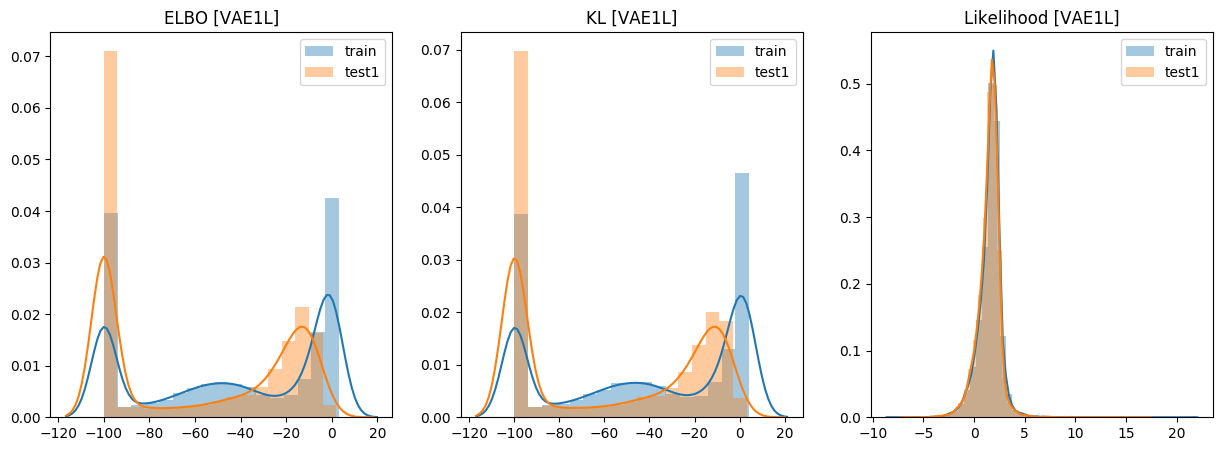

In [80]:
dataset = fashion_mnist
models = models_fashion_mnist

x_train, y_train = dataset['x_train'], dataset['y_train']
x_test1, y_test1 = dataset['x_test1'], dataset['y_test1']
for abbr, model in models.items():
    with torch.no_grad():
        copy_latents = dict(z1=False, z2=False) if model.n_layers > 1 else None
        
        torch.manual_seed(0)
            
        elbo_train, kl_train, likelihood_train = model.elbo(torch.FloatTensor(x_train), importance_samples=1,
                                                            copy_latents=copy_latents)
        elbo_test1, kl_test1, likelihood_test1 = model.elbo(torch.FloatTensor(x_test1), importance_samples=1,
                                                            copy_latents=copy_latents)
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

    seaborn.distplot(elbo_train.clamp(-100), kde_kws={}, ax=ax1, label='train')
    seaborn.distplot(elbo_test1.clamp(-100), kde_kws={}, ax=ax1, label='test1')
    seaborn.distplot(kl_train.clamp(-100), kde_kws={}, ax=ax2, label='train')
    seaborn.distplot(kl_test1.clamp(-100), kde_kws={}, ax=ax2, label='test1')
    seaborn.distplot(likelihood_train.clamp(-100), kde_kws={}, ax=ax3, label='train')
    seaborn.distplot(likelihood_test1.clamp(-100), kde_kws={}, ax=ax3, label='test1')

    ax1.set_title(f'ELBO [{abbr.upper()}]')
    ax2.set_title(f'KL [{abbr.upper()}]')
    ax3.set_title(f'Likelihood [{abbr.upper()}]')
    ax1.legend()
    ax2.legend()
    ax3.legend()

## Animate generation during training

In [104]:
import matplotlib.pyplot as plt
import natsort

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [112]:
from IPython import embed
def get_substring_digit(s):
    return int(''.join([ss for ss in s if ss.isdigit()]))

def get_training_samples(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('model_samples.npy'):
            epoch = get_substring_digit(f)
            npys[epoch] = np.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

def get_training_latents(run_id):
    npys = dict()
    for f in os.listdir(os.path.join(experiments_dir, str(run_id))):
        if f.endswith('model_latents.pkl'):
            epoch = get_substring_digit(f)
            npys[epoch] = torch.load(os.path.join(experiments_dir, str(run_id), f))
    return npys

In [113]:
run_id = '6867'
samples = get_training_samples(run_id)
latents = get_training_latents(run_id)

ValueError: invalid literal for int() with base 10: ''

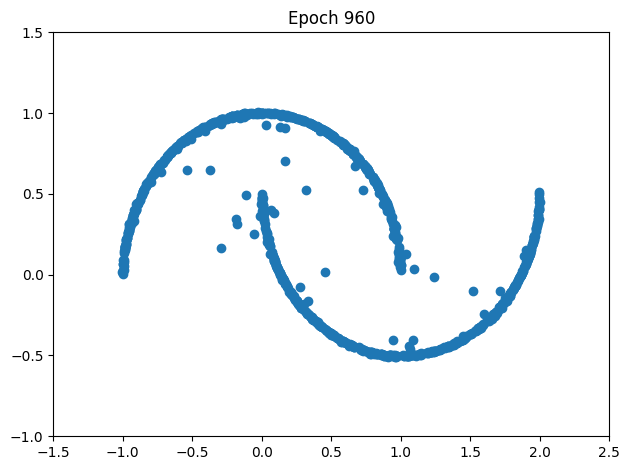

In [109]:
fig, ax = plt.subplots()
fig.set_tight_layout(True)
scat = ax.scatter([], [])

def init():
    return (scat, )

def update(i):
    scat.set_offsets(npys[i])
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1, 1.5])
    ax.set_title(f'Epoch {i}')
    return (scat, )
    
    
epochs_sorted = natsort.natsorted(npys.keys())
anim = FuncAnimation(fig,
                     update,
                     frames=[*epochs_sorted[:1]*10, *epochs_sorted, *epochs_sorted[-1:]*10], 
                     init_func=init,
                     interval=150,
                     blit=True)

HTML(anim.to_html5_video())

In [679]:
anim.save(f'training_samples_{run_id}.mp4', codec='h264')